# Purpose

The purpose of this notebook is to show how to set observation and virtual evidence. There are 3 types of evidence described in the original Huang paper.

* virtual evidence: each likelihood must be in the range $[0, 1]$.
* finding evidence: all likelihoods must be exactly 1.0 or 0.0.
* observation evidence: exactly one likelihood is 1.0 and all others must be 0.0.

In [1]:
from pybbn.graph.dag import BbnUtil
from pybbn.graph.jointree import EvidenceBuilder, EvidenceType
from pybbn.pptc.inferencecontroller import InferenceController
import pandas as pd

def potential_to_df(p):
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        t = (name, df)
        data.append(t)
    return data

# get the pre-defined huang graph
bbn = BbnUtil.get_huang_graph()

# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

Now, get the marginal probabilities without any evidence and with observation or virtual evidences.

In [2]:
marginal_dfs = potentials_to_dfs(join_tree)

ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('e')) \
    .with_evidence('on', 1.0) \
    .build()
join_tree.unobserve_all()
join_tree.set_observation(ev)
observe_dfs = potentials_to_dfs(join_tree)

ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('e')) \
    .with_evidence('on', 0.5) \
    .with_evidence('off', 0.1) \
    .with_type(EvidenceType.VIRTUAL) \
    .build()
join_tree.unobserve_all()
join_tree.set_observation(ev)
virtual1_dfs = potentials_to_dfs(join_tree)

ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('e')) \
    .with_evidence('on', 0.1) \
    .with_evidence('off', 0.5) \
    .with_type(EvidenceType.VIRTUAL) \
    .build()
join_tree.unobserve_all()
join_tree.set_observation(ev)
virtual2_dfs = potentials_to_dfs(join_tree)

all_dfs = []
for i in range(len(marginal_dfs)):
    all_dfs.append(marginal_dfs[i])
    all_dfs.append(observe_dfs[i])
    all_dfs.append(virtual1_dfs[i])
    all_dfs.append(virtual2_dfs[i])

Plot the marginal probabilities.

* The first column are the marginal probabilities without any observations.
* The second column are the marginal probabiliities with e='on' observation evidence.
* The third column are the marginal probabilites with e='on' at 0.5 and e='off' at 0.1 virtual evidence.
* The third column are the marginal probabilites with e='on' at 0.1 and e='off' at 0.5 virtual evidence.

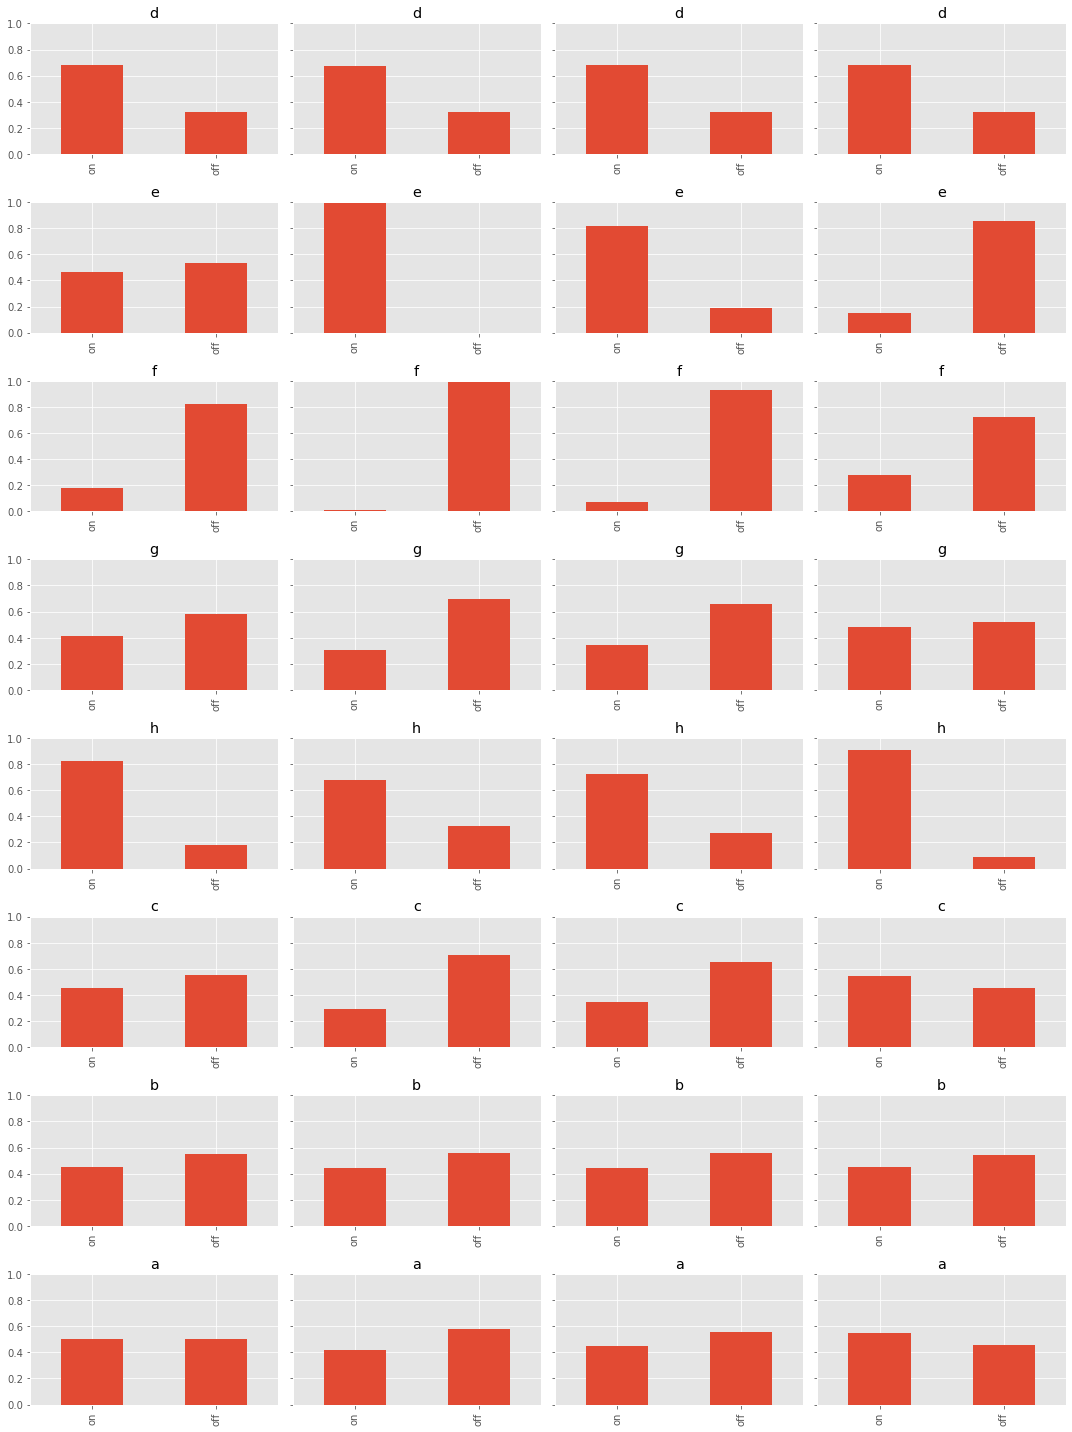

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(37)
plt.style.use('ggplot')

fig, axes = plt.subplots(len(marginal_dfs), 4, figsize=(15, 20), sharey=True)
for i, ax in enumerate(np.ravel(axes)):
    all_dfs[i][1].plot.bar(x='val', y='p', legend=False, ax=ax)
    ax.set_title(all_dfs[i][0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('')
plt.tight_layout()